In [1]:
# The Purpose is to build the NLP Model that can read the medical abstracts easier

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git # Clone the Dataset from the git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 5.98 MiB/s, done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Download helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import calculate_results

--2023-05-01 04:38:48--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-05-01 04:38:48 (84.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
#Looking what files are there in pubmet 20k
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign
# Check what files are in the PubMed_20K dataset 
!ls pubmed-rct/PubMed_20k_RCT

dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


In [5]:
data_directory='/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'#Data Directory

In [6]:
import os

In [7]:
filenames=[data_directory+filename for filename in os.listdir(data_directory)]

In [8]:
filenames#Getting the files Train data,Validation data,Test data

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

#Processing the data

In [9]:
#Knowing the train dataset

In [10]:
def get_lines(filepath):#Reading the data in the path
  with open(filepath,'r') as f:
     return f.readlines()


In [11]:
train_lines=get_lines(data_directory+'train.txt')

In [12]:
train_lines[:100] #Knowing about the abstarcts in the file

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [13]:
def preprocess_text_with_line_numbers(filename):
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [14]:
# Get data from file and preprocess it Train data,validation data and the test data
%%time
train_samples = preprocess_text_with_line_numbers(data_directory + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_directory + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_directory + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 352 ms, sys: 69.3 ms, total: 422 ms
Wall time: 424 ms


(180040, 30212, 30135)

In [15]:
train_samples[:20] #Train Samples

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [16]:
import pandas as pd #Visualize the Dictionary and converting to Data Frame and visualizing that
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


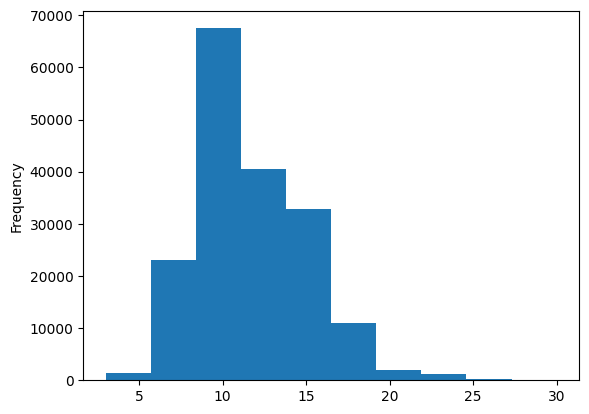

In [17]:
train_df.total_lines.plot.hist();

In [18]:
# Extract labels ("target" columns) and encode them into integers 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [20]:
# Get class names and number of classes from LabelEncoder instance 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [21]:
# Convert abstract text lines into lists 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

#BaseLine Model

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer#Importing the TfidfVectorizer,Decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf",  DecisionTreeClassifier(max_depth=50))
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, 
            y=train_labels_encoded);

In [23]:
model_0.score(X=val_sentences,
              y=val_labels_encoded)#Evaluate on Validation data

0.6967761154508142

In [24]:
test_pred=model_0.predict(test_sentences)#Testing on test data

#Testing Baseline Model results

In [25]:
calculate_results(test_labels_encoded,test_pred)#Getting the accuarcy ,precision ,recall and F1 

{'accuracy': 68.9795918367347,
 'precision': 0.6840100239710493,
 'recall': 0.689795918367347,
 'f1': 0.685174244190681}

In [26]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

#Preparing the model for the neural networks

In [27]:
import tensorflow as tf #Importing Required Libraries
import pandas as pd
import numpy as np
from tensorflow.keras import layers

In [28]:
train_sentences[:10]#Going Through at the train sentences

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [29]:
sen_lens=[len(sentence.split()) for sentence in train_sentences]#Knowing about the average sentence Length
avg_sen_len=np.mean(sen_lens)
avg_sen_len

26.338269273494777

(array([1.25846e+05, 4.78220e+04, 5.37600e+03, 7.86000e+02, 1.46000e+02,
        3.20000e+01, 1.90000e+01, 8.00000e+00, 3.00000e+00, 2.00000e+00]),
 array([  1. ,  30.5,  60. ,  89.5, 119. , 148.5, 178. , 207.5, 237. ,
        266.5, 296. ]),
 <BarContainer object of 10 artists>)

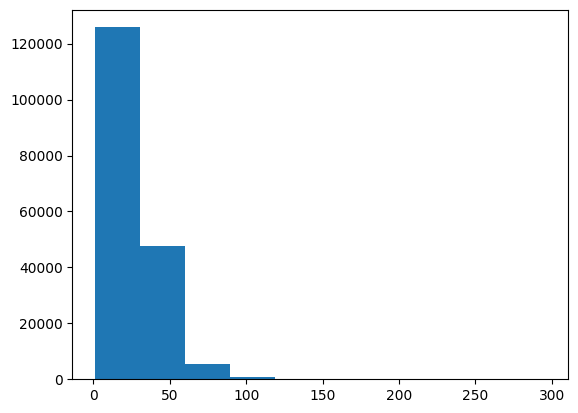

In [30]:
import matplotlib.pyplot as plt#Plot no of tokens in each sentence
plt.hist(sen_lens,bins=10)

#Creating the text vectorization layer

In [31]:
output_seq_len=int(np.percentile(sen_lens,95))
output_seq_len #no of tokens that cover 95% of the data

55

In [32]:
#Here we are mapping our texts from words to numbers

In [33]:
max_tokens=68000 #Max no of words in the text

In [34]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization #Importing the text vectorization 

In [35]:
text_vectorization=TextVectorization(max_tokens=max_tokens,
                                     output_sequence_length=output_seq_len,)#Max Tokens is the max number of words in Vocabulary that is common
#OUTPUT sequence length is the max out sequence length that most of the len of statements cover

In [36]:
text_vectorization.adapt(train_sentences)

In [37]:
import random
ran_sen=random.choice(train_sentences)
ran_text=text_vectorization([ran_sen]) #Testing the text vectorizer

In [38]:
ran_text

<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[ 1493,     5,     2,    17,   441,     9,  1162,     5, 31091,
         2690,     4,  9313,   307,    64,     3,   145,    67,     9,
           92,   630,    27,    97,  2870,  2007,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]])>

#Knowing about the vocabulary

In [39]:
getting_vocab=text_vectorization.get_vocabulary() #The most common used vocab and the least common used vocab
print(f'The Most Frequent words:{getting_vocab[:5]}')
print(f'The Less Frequent words:{getting_vocab[-5:]}')



The Most Frequent words:['', '[UNK]', 'the', 'and', 'of']
The Less Frequent words:['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [40]:
text_vectorization.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

#Creating the Embedding layer

In [41]:
embeded_layer=layers.Embedding(input_dim=len(getting_vocab),output_dim=128,mask_zero=True,name="Token_Embedding")#The embedding layer after using the text vectorization

In [42]:
#Testing the layers

In [43]:
target_sen=random.choice(train_sentences) #Testing the Embedding layer on the random sequence
target_sen_vec=text_vectorization([target_sen])
print(f'The target sen Before Vec is {target_sen}')
print(f'The target sen vec is {target_sen_vec}')
embed_layer=embeded_layer(target_sen_vec)
print(f'The embedded layer is {embed_layer}')

The target sen Before Vec is no severe adverse events were noted in any patient during the study period .
The target sen vec is [[ 33 289 118 124   9 991   5 262 127  52   2  17 173   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]
The embedded layer is [[[ 0.03543595  0.02162861 -0.04289929 ... -0.02234229  0.0319518
   -0.01809762]
  [-0.01235729  0.02691669  0.01290888 ... -0.04459108  0.04192592
    0.00844596]
  [-0.0226521   0.01843065 -0.00660639 ...  0.00956458 -0.01418997
    0.01963761]
  ...
  [-0.01120341 -0.0328212  -0.03799621 ... -0.02199611  0.02861058
    0.02519039]
  [-0.01120341 -0.0328212  -0.03799621 ... -0.02199611  0.02861058
    0.02519039]
  [-0.01120341 -0.0328212  -0.03799621 ... -0.02199611  0.02861058
    0.02519039]]]


In [44]:
#Converting the datasets into tensorflow datasets

In [45]:
train_dataset=tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_encoded))
val_dataset=tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_encoded))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_encoded))

In [46]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [47]:
#Take the tensorslicedataset and turn them into fetched dataset we can process the data quickly

In [48]:
train_dataset=train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [49]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [50]:
#Model Building

In [51]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [52]:
num_classes

5

#Model 1

In [53]:
#First we are buiding the ConvlD model that is used for the sequence text classification

In [54]:
inputs=layers.Input(shape=(1,),dtype=tf.string) #input shape
text_vectorizer=text_vectorization(inputs)
token_embedded=embeded_layer(text_vectorizer)
x=layers.Conv1D(64,kernel_size=5,padding='same',activation='relu')(token_embedded)#ACTIVATION relu
x=layers.GlobalAveragePooling1D()(x)
outputs=layers.Dense(5,activation='softmax')(x)#OUTPUT neurons 5
model_1=tf.keras.Model(inputs,outputs)

In [55]:
model_1.compile(loss="sparse_categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [56]:
model_1.summary()#Model summary

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 Token_Embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [57]:
#Fitting the model on the train data and validation on the validation data

In [58]:
model_1_his=model_1.fit(train_dataset,steps_per_epoch=int(len(train_dataset)),epochs=5,validation_data=val_dataset,validation_steps=int(len(val_dataset)))

Epoch 1/5
5627/5627 [==============================] - 92s 14ms/step - loss: 0.6135 - accuracy: 0.7771 - val_loss: 0.5343 - val_accuracy: 0.8107
Epoch 2/5
5627/5627 [==============================] - 37s 7ms/step - loss: 0.4509 - accuracy: 0.8420 - val_loss: 0.5326 - val_accuracy: 0.8110
Epoch 3/5
5627/5627 [==============================] - 38s 7ms/step - loss: 0.3698 - accuracy: 0.8725 - val_loss: 0.5671 - val_accuracy: 0.8059
Epoch 4/5
5627/5627 [==============================] - 37s 6ms/step - loss: 0.3055 - accuracy: 0.8982 - val_loss: 0.6296 - val_accuracy: 0.8007
Epoch 5/5
5627/5627 [==============================] - 37s 7ms/step - loss: 0.2516 - accuracy: 0.9183 - val_loss: 0.7086 - val_accuracy: 0.7934


In [59]:
model_1_prediction = model_1.predict(test_dataset)
model_1_prediction#Predicting on the test data

942/942 [==============================] - 2s 2ms/step


array([[6.11283839e-01, 5.18634133e-02, 2.37891339e-02, 2.41970137e-01,
        7.10934773e-02],
       [1.56746630e-03, 6.22008520e-04, 4.02936697e-01, 6.29569229e-04,
        5.94244242e-01],
       [1.87035548e-05, 1.01741214e-04, 9.57616091e-01, 4.26177357e-05,
        4.22209054e-02],
       ...,
       [1.18387379e-05, 5.81111293e-03, 6.07945913e-05, 2.20151378e-06,
        9.94114101e-01],
       [1.26648264e-03, 7.01006548e-03, 7.19299191e-04, 1.54512556e-04,
        9.90849614e-01],
       [4.12374677e-04, 2.44269762e-02, 4.74241413e-02, 9.24271899e-06,
        9.27727222e-01]], dtype=float32)

In [60]:
model_1_prediction_result= tf.argmax(model_1_prediction, axis=1)
model_1_prediction_result #Using argmax to know the labels

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([0, 4, 2, ..., 4, 4, 4])>

In [61]:
model_1_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_1_prediction_result)
model_1_results #Calculating the accuracy ,precision,recall F1 SCORE

{'accuracy': 78.5100381616061,
 'precision': 0.7811867618295214,
 'recall': 0.7851003816160611,
 'f1': 0.7820846709809371}

In [62]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report#Importing the libraries
from sklearn.metrics import confusion_matrix


In [63]:
accuracy_of_model=accuracy_score(test_labels_encoded,model_1_prediction_result)

In [64]:
accuracy_of_model#Accuracy

0.7851003816160611

In [65]:
confusion_matrix(test_labels_encoded,model_1_prediction_result) #Confusion matrix

array([[2278,  530,  286,  443,   84],
       [ 424, 3188,  175,  101,  683],
       [ 149,  124, 8668,   78,  878],
       [ 782,  198,  202, 1102,   49],
       [  57,  454,  762,   17, 8423]])

#HyperParameter Tunning Model 1

In [66]:
#After building the conv1d model then we here added the layers to increase the accuracy

In [67]:
inputs=layers.Input(shape=(1,),dtype=tf.string)
text_vectorizer=text_vectorization(inputs)
token_embedded=embeded_layer(text_vectorizer)
x=layers.Conv1D(128,kernel_size=3,padding='valid',activation='relu')(token_embedded)
x = layers.Dropout(0.2)(x)  # Dropout layer with 20% dropout rate
x=layers.GlobalAveragePooling1D()(x)
# Add more layers
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.5)(x)#Dropout
outputs=layers.Dense(5,activation='softmax')(x)
model_1_hyper=tf.keras.Model(inputs,outputs)

In [68]:
model_1_hyper.compile(loss="sparse_categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])#Compiling the model

In [69]:
model_1_hyper.summary()#Model summary

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 Token_Embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d_1 (Conv1D)           (None, 53, 128)           49280     
                                                                 
 dropout (Dropout)           (None, 53, 128)           0         
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                  

In [70]:
#Fitting the model

In [71]:
model_1_his=model_1_hyper.fit(train_dataset,steps_per_epoch=int(len(train_dataset)),epochs=5,batch_size=64,validation_data=val_dataset,validation_steps=int(len(val_dataset)))

Epoch 1/5
5627/5627 [==============================] - 82s 14ms/step - loss: 0.4012 - accuracy: 0.8688 - val_loss: 0.7433 - val_accuracy: 0.7797
Epoch 2/5
5627/5627 [==============================] - 42s 7ms/step - loss: 0.2926 - accuracy: 0.9094 - val_loss: 0.8807 - val_accuracy: 0.7826
Epoch 3/5
5627/5627 [==============================] - 40s 7ms/step - loss: 0.2512 - accuracy: 0.9232 - val_loss: 1.0642 - val_accuracy: 0.7641
Epoch 4/5
5627/5627 [==============================] - 39s 7ms/step - loss: 0.2201 - accuracy: 0.9322 - val_loss: 1.1230 - val_accuracy: 0.7772
Epoch 5/5
5627/5627 [==============================] - 40s 7ms/step - loss: 0.1951 - accuracy: 0.9401 - val_loss: 1.2672 - val_accuracy: 0.7751


In [72]:
model_1_hyper_prediction = model_1_hyper.predict(test_dataset)
model_1_hyper_prediction#Predicting on the test data

942/942 [==============================] - 2s 2ms/step


array([[7.93476880e-01, 4.92351018e-02, 2.36958470e-02, 1.30428702e-01,
        3.16343037e-03],
       [9.71172296e-04, 1.47777284e-02, 1.63694154e-02, 1.65561170e-04,
        9.67716038e-01],
       [6.06699141e-05, 4.20727774e-05, 9.74270344e-01, 3.69199988e-05,
        2.55898759e-02],
       ...,
       [2.63479933e-06, 1.09288783e-03, 8.13926599e-05, 1.59337716e-07,
        9.98822868e-01],
       [1.13505324e-04, 6.59903511e-03, 1.58946693e-03, 1.42879189e-05,
        9.91683722e-01],
       [5.47491936e-07, 6.18598051e-06, 2.05876204e-04, 6.06245956e-11,
        9.99787390e-01]], dtype=float32)

In [73]:
model_1_hyper_prediction_result= tf.argmax(model_1_hyper_prediction, axis=1)
model_1_hyper_prediction_result#Predicting on the test data

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([0, 4, 2, ..., 4, 4, 4])>

In [74]:
model_1_hyper_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_1_hyper_prediction_result)
model_1_hyper_results #Calculating the accuracy ,precision,recall F1 SCORE

{'accuracy': 76.67828106852497,
 'precision': 0.7645430817897965,
 'recall': 0.7667828106852497,
 'f1': 0.7633560388387476}

#Model2

In [75]:
#RNN MODEL This is the second model Recurrent neural network

In [76]:
inputs=layers.Input(shape=(1,),dtype=tf.string)
text_vectorizer=text_vectorization(inputs)#Tokenization
token_embedded=embeded_layer(text_vectorizer) #Embedding
x=layers.SimpleRNN(128,activation='relu')(token_embedded)
x=layers.Dense(64,activation='relu')(x) #Adding layers
#x=layers.GlobalAveragePooling1D()(x)
outputs=layers.Dense(5,activation='softmax')(x)
model_2=tf.keras.Model(inputs,outputs) 
model_2.compile(loss="sparse_categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [77]:
model_2.summary() #model summary

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 Token_Embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 5)                 325       
                                                           

In [78]:
#Fitting the RNN model on the train data and validating on the test data

In [79]:
model_2_his=model_2.fit(train_dataset,steps_per_epoch=int(len(train_dataset)),epochs=5,validation_data=val_dataset,validation_steps=int(len(val_dataset)))

Epoch 1/5
5627/5627 [==============================] - 554s 98ms/step - loss: 0.3937 - accuracy: 0.8640 - val_loss: 0.7435 - val_accuracy: 0.7761
Epoch 2/5
5627/5627 [==============================] - 533s 95ms/step - loss: 0.2902 - accuracy: 0.9048 - val_loss: 0.7780 - val_accuracy: 0.7689
Epoch 3/5
5627/5627 [==============================] - 519s 92ms/step - loss: 0.2538 - accuracy: 0.9176 - val_loss: 0.8555 - val_accuracy: 0.7681
Epoch 4/5
5627/5627 [==============================] - 512s 91ms/step - loss: 0.2249 - accuracy: 0.9275 - val_loss: 0.8708 - val_accuracy: 0.7730
Epoch 5/5
5627/5627 [==============================] - 512s 91ms/step - loss: 0.2074 - accuracy: 0.9331 - val_loss: 0.9372 - val_accuracy: 0.7721


In [80]:
model_2_prediction = model_2.predict(test_dataset)
model_2_prediction

942/942 [==============================] - 10s 10ms/step


array([[9.4921190e-01, 1.6282063e-03, 1.6884712e-04, 4.8324201e-02,
        6.6679815e-04],
       [2.2174215e-02, 6.0874461e-03, 1.4519370e-01, 1.3068288e-03,
        8.2523775e-01],
       [2.1616679e-03, 4.3918935e-04, 9.5868063e-01, 3.6571061e-03,
        3.5061385e-02],
       ...,
       [8.4394564e-08, 7.8817997e-05, 9.9593235e-06, 2.2695421e-09,
        9.9991107e-01],
       [5.9942325e-04, 9.2750452e-03, 3.9409050e-03, 1.1745716e-04,
        9.8606724e-01],
       [8.0858573e-04, 4.3307892e-03, 7.5775608e-02, 2.9186375e-04,
        9.1879314e-01]], dtype=float32)

In [81]:
model_2_prediction_result= tf.argmax(model_2_prediction, axis=1)
model_2_prediction_result#Predicting on the test data

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([0, 4, 2, ..., 4, 4, 4])>

In [82]:
#evaluating results Precision recall and F1 score

In [83]:
model_2_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_2_prediction_result)
model_2_results #Results

{'accuracy': 76.80438028870084,
 'precision': 0.7702662020124156,
 'recall': 0.7680438028870085,
 'f1': 0.7657185382314029}

#Model 3

In [84]:
#After Conv1D,RNN and the third model we build is LSTM Long short term memory

In [85]:
inputs=layers.Input(shape=(1,),dtype=tf.string)
text_vectorizer=text_vectorization(inputs)
token_embedded=embeded_layer(text_vectorizer)
x=layers.LSTM(64)(token_embedded)
#x=layers.GlobalAveragePooling1D()(x)
outputs=layers.Dense(5,activation='softmax')(x)
model_3=tf.keras.Model(inputs,outputs) 

In [86]:
model_3.compile(loss="sparse_categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [87]:
model_3.summary() #LSTM model summary

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 Token_Embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 5)                 325       
                                                                 
Total params: 8,349,381
Trainable params: 8,349,381
Non-trainable params: 0
_________________________________________________

In [88]:
#Fitting the model on train data and validating on the validation data

In [89]:
model_3_his=model_3.fit(train_dataset,steps_per_epoch=int(len(train_dataset)),epochs=5,validation_data=val_dataset,validation_steps=int(len(val_dataset)))

Epoch 1/5
5627/5627 [==============================] - 106s 18ms/step - loss: 0.2292 - accuracy: 0.9226 - val_loss: 0.8556 - val_accuracy: 0.7724
Epoch 2/5
5627/5627 [==============================] - 71s 13ms/step - loss: 0.1501 - accuracy: 0.9504 - val_loss: 1.0027 - val_accuracy: 0.7686
Epoch 3/5
5627/5627 [==============================] - 71s 13ms/step - loss: 0.1193 - accuracy: 0.9608 - val_loss: 1.0863 - val_accuracy: 0.7685
Epoch 4/5
5627/5627 [==============================] - 68s 12ms/step - loss: 0.0982 - accuracy: 0.9679 - val_loss: 1.2135 - val_accuracy: 0.7713
Epoch 5/5
5627/5627 [==============================] - 71s 13ms/step - loss: 0.0821 - accuracy: 0.9735 - val_loss: 1.2565 - val_accuracy: 0.7660


In [90]:
model_3_prediction = model_3.predict(test_dataset)
model_3_prediction

942/942 [==============================] - 5s 4ms/step


array([[8.54541838e-01, 2.37056855e-02, 1.75192673e-02, 1.02637760e-01,
        1.59550249e-03],
       [1.20909866e-02, 5.13407867e-03, 8.26166928e-01, 3.37004079e-03,
        1.53237998e-01],
       [1.10523775e-04, 4.65982557e-05, 9.93951201e-01, 5.54612488e-04,
        5.33709070e-03],
       ...,
       [1.50553278e-05, 2.33687740e-03, 2.17330919e-04, 1.16387382e-05,
        9.97419119e-01],
       [1.54479014e-04, 7.88801908e-02, 9.36791941e-04, 1.57257455e-04,
        9.19871271e-01],
       [4.67985265e-05, 2.09667650e-03, 9.38544399e-05, 6.95509789e-06,
        9.97755706e-01]], dtype=float32)

In [91]:
model_3_prediction_result= tf.argmax(model_3_prediction, axis=1)
model_3_prediction_result #Predicting on the test data

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([0, 2, 2, ..., 4, 4, 4])>

In [92]:
model_3_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_3_prediction_result)
model_3_results #Evaluating the results

{'accuracy': 75.59316409490626,
 'precision': 0.7552776487736308,
 'recall': 0.7559316409490625,
 'f1': 0.7550687823789778}

#Model4

In [93]:
#Taking the example abstract and testing the model 

In [94]:
example='This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.'



In [95]:
example.split('.')

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs',
 ' Participants were randomly assigned to treatment or wait-list conditions',
 ' Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language',
 ' A response-cost program was applied to reduce problem behaviors and foster skills acquisition',
 ' Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures)',
 ' Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents',
 ' High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity',
 ' Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group',
 '']

In [96]:
model_0.predict(example.split('.'))

array([1, 2, 4, 2, 4, 2, 4, 2, 2])

In [97]:
model_1.predict(example.split('.'))

1/1 [==============================] - 0s 138ms/step


array([[1.11115359e-01, 1.80860639e-01, 5.25506496e-01, 1.30784530e-02,
        1.69439048e-01],
       [2.99964217e-03, 2.99824496e-05, 9.74276006e-01, 4.26984718e-03,
        1.84245817e-02],
       [4.33151834e-02, 4.31704335e-02, 8.99316728e-01, 8.46420880e-03,
        5.73344668e-03],
       [4.36682403e-01, 6.61152229e-02, 1.44169107e-01, 4.00158726e-02,
        3.13017368e-01],
       [8.13790073e-04, 3.24694416e-03, 4.11772076e-03, 5.43567912e-05,
        9.91767228e-01],
       [8.48262705e-09, 2.36619849e-06, 1.81692883e-09, 2.73522677e-10,
        9.99997616e-01],
       [2.82475092e-02, 2.44163312e-02, 2.52420336e-01, 2.46596728e-02,
        6.70256138e-01],
       [1.07853196e-03, 3.81992105e-03, 4.04619202e-02, 3.97582568e-04,
        9.54241991e-01],
       [1.55220374e-01, 1.03234164e-01, 3.48994881e-01, 9.38641056e-02,
        2.98686445e-01]], dtype=float32)

In [98]:
tf.argmax(model_1.predict(example.split('.')), axis=1)

1/1 [==============================] - 0s 32ms/step


<tf.Tensor: shape=(9,), dtype=int64, numpy=array([2, 2, 2, 0, 4, 4, 4, 4, 2])>

In [99]:
label_encoder.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)